In [1]:
import numpy as np
from funcs.models import model_ND

##### Below is a generalised model of simple_model.ipynb, allowing for any number of segments and any number of branches.
This model has a few assumptions:
* 1D model, each segment can only transfer heat to neighbouring segments
* There is a heat source which supplies (or draws) heat from segment 0, the magnitude of which is set by Q_in
* The final segment may disspiate heat to surroundings. The outside temperature is set by T_out.

In [2]:
# Example 1: single segment 
k = 500
c = 1e6
T = 15.0
iterations = 1000
T_out = np.full(iterations+1, 10)
heatinput = np.full(iterations+1,1000)
# Initialise class with system parameters
sys_1 = model_ND('Single segment', k, c, T, T_out, heatinput)

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
times = np.linspace(0, 5e3, iterations+1)
Ts = sys_1.run(times=times)


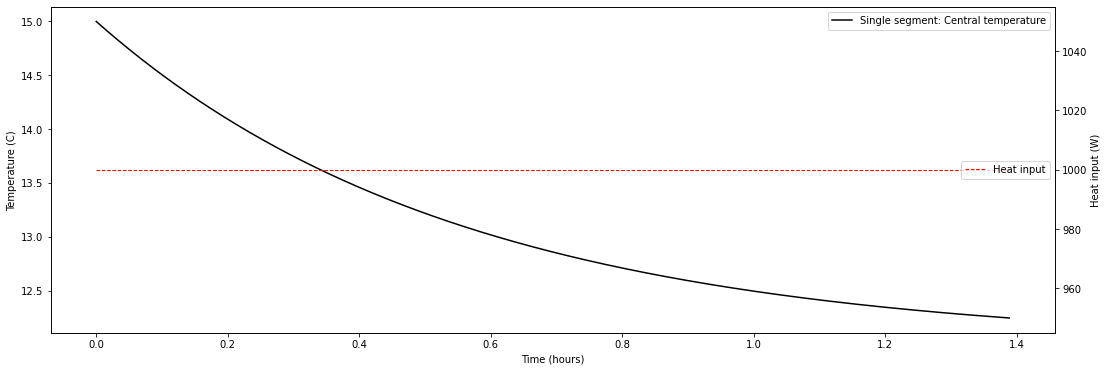

In [3]:
sys_1.plot();

In [4]:
# More complex example, 7 segments in series
k = [800.0, 500.0, 300.0, 150.0, 400.0, 1000.0, 200.0]
c = [6e5, 2.5e6, 1.1e7, 1.5e7, 2.1e5, 6.5e6, 6.9e6]
T = [15.0, 20.0, 10.0, 17.0, 25.0, 30.0, 21.0]
iterations = 1000
T_out = np.full(iterations+1, 10)
heatinput = np.full(iterations+1,1000)
# Initialise class with system parameters
sys_2 = model_ND('7 segments', k, c, T, T_out, heatinput)

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
times = np.linspace(0, 5e3, iterations+1)
Ts = sys_2.run(times=times)

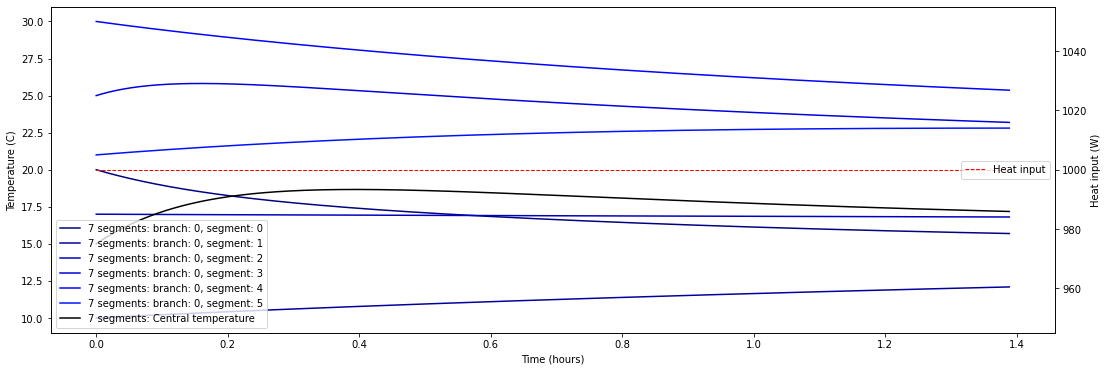

In [5]:
sys_2.plot();

In [6]:
# Example 3: Three branches, two segments each
k = [[1000.0, 1500.0], [2000.0, 3000.0], [1500.0, 3000.0]]
c = [[1e6, 1e7], [2e6, 1e6], [1e8, 1e5]]
T = [[10.0, 6.0], [10.0, 17.0], [10.0, 8.0]] # first entry in each sub array must be the same, it is the temperature of the central node

iterations = 1000
T_out = np.full((iterations+1,3), 10)
heatinput = np.full(iterations+1,1000)

# Initialise class with system parameters
sys_3 = model_ND('3 branches, 2 segments', k, c, T, T_out, heatinput)

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
times = np.linspace(0, 5e3, iterations+1)
Ts = sys_3.run(times=times)

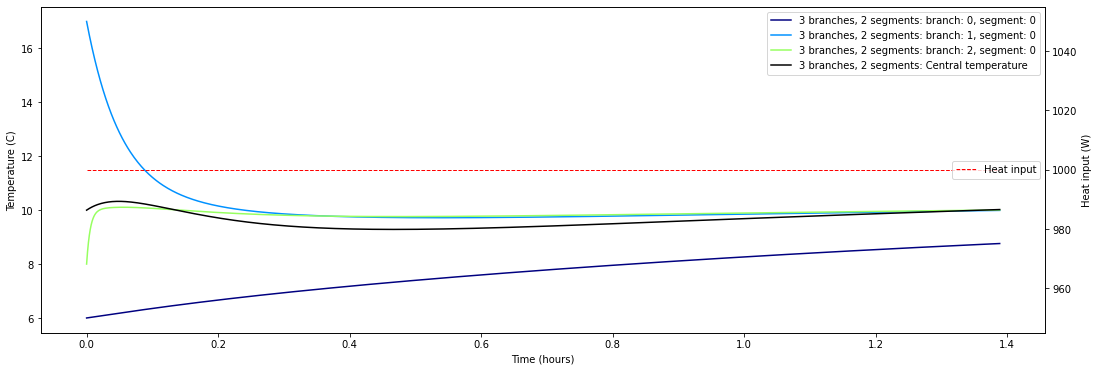

In [7]:
sys_3.plot();